In [1]:
%matplotlib inline
import re
import nltk
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import joblib
from joblib import Parallel, delayed
from tqdm.notebook import tqdm as tqdm
from tqdm.notebook import trange
import contextlib
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import edward2 as ed
import tensorflow as tf
from scipy.special import digamma
from pickle import dump, load
from scipy.sparse import csr_matrix
import tensorflow_probability as tfp
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
import os
import sys
import time

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# tensorflow does not work with new numpy versions



In [2]:
tqdm.pandas()

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()  

In [3]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\denis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\denis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\denis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# data_proc = pd.read_pickle('data_proc.pkl')
# data_enc = pd.read_pickle('data.pkl')
# with open('word_to_idx.pkl', 'rb') as f:
#     words_to_idx = load(f)

In [5]:
n = 1000
seed = 42
data = pd.read_csv('nips-papers/papers.csv')
data = data[['paper_text']]
data_n = data.sample(n=n, random_state=42)

In [6]:
def preproc_func(text, stop_words):
    text = text.lower()
    text = re.sub(r'(\d+)', '', text)
    text = re.sub(r'(\n)|(\t)', ' ', text)
    text = text.translate({ ord(c): None for c in string.punctuation })
    text = text.strip()
    
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    text = [i for i in tokens if not i in stop_words and len(i) > 1]
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

with tqdm_joblib(tqdm(desc="Preprocessing", total=len(data_n))) as progress_bar:
    stop_words = set(stopwords.words('english'))
    data_proc = Parallel(n_jobs=1)(delayed(preproc_func)(text, stop_words) for text in data_n['paper_text'])
    data_proc = pd.Series(data_proc, index=data_n.index, name='paper_text')

Preprocessing:   0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
data_proc.head()

509     [independent, component, analysis, identificat...
2576    [nearmaximum, entropy, model, binary, neural, ...
6362    [nearestneighbor, sample, compression, efficie...
6173    [efficient, highorder, interactionaware, featu...
6552    [multioutput, polynomial, network, factorizati...
Name: paper_text, dtype: object

In [8]:
def encode2(text, word_dict):
    return np.asarray(word_dict.doc2idx(text))

word_dict = Dictionary(data_proc)
data_enc = data_proc.progress_apply(lambda x: encode2(x, word_dict))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
# data_proc.to_pickle('data_proc.pkl')
# data_enc.to_pickle('data.pkl')

# with open('word_to_idx.pkl', 'wb') as f:
#     dump(words_to_idx, f)

In [10]:
data_train = data_enc.iloc[:n]
# data_test = data_enc.iloc[n:]

K = 10
D = len(data_train)
Ns = data_train.apply(lambda x: len(x)).to_numpy().astype(int)
N = Ns.sum()
V = len(word_dict)

In [11]:
print(K, D, Ns, N, V)

10 1000 [1473 2453 3310 3107 3017 1621 1727 1618 3434 1774 1454 1339 2501 1669
 1785 1426 1956 2017 2192 1927 2614 2839 1642 2324 1934 3103 3264 2957
 2776 1736 3298 2756 1244 1501 1855 1112 1979 2687 1972 2950 2946 2881
 2925 2306 2767 3010 1629 1468 2904 1105 1847 1282 1463 2645 2189 3190
 1907 1033 2197 1437 3537 2117 1484 2646 2227 2141 3498 1673 2113 2894
 2744 1479 1917 3173 2566 2640 2765 2451 2814 2804 1580 1656 1806 2439
 2567 2834 2827 2455 2306 1458 3056 2524 1648 2298 1153 3384 2860 3158
 2646 1954 1528 2982 3448 2121 2763 1014 1341 2743 1526 2570 1567 2648
 2656 2928 1780 3461 1632 1933 2607 2824 1440 1640 1415 3076 2959 1928
 2720 2892 1783 2812 1808 2748 3864 3005 1900 2596 2054 3367 1645 2022
 1444 1626 2450 1141 2159 3403 1759 2249 2328 3547 1293 2966 2492 2769
 2740 3336 2322 3702 2817 2609 2182 3309 2794 2126 1744 1719 1765 2951
 1898 2843 2742 1516 1760 1893 2295 2021 1824 1721 1429 3663 2712 2831
 2555 1205 2662 2872  841 2469 2128 2992 3142 2451 1729 1836 1933 110

In [12]:
def create_indices(data, D, K, V):
    Ns = np.empty(D, dtype=int)
     
    for i, doc in enumerate(data):
        Ns[i] = len(doc)
    
    N = Ns.sum()
    rows = np.empty(N, dtype=np.int64)
    cols = np.empty(N, dtype=np.int64)
    v_cols = np.empty(N, dtype=np.int64)
    
    last_idx = 0
    
    for i, doc in tqdm(enumerate(data), total=D):
        n = len(doc)
        rows[last_idx:last_idx+n] = i
        cols[last_idx:last_idx+n] = np.arange(n, dtype=np.int64)
        v_cols[last_idx:last_idx+n] = doc
        last_idx += n
        
    K_idx = np.tile(np.arange(K), N)
    left_indices = np.stack((K_idx, np.repeat(v_cols, K)), axis=1)
    dt_indices = np.stack((np.repeat(rows, K), K_idx), axis=1)
    
    return left_indices, dt_indices, N, Ns

In [13]:
# Did not optimize much, as we use it only once
@tf.function
def init_matrices_internal(data_ragged, alpha, beta, D, N, K, V, Ns):
    dt = tf.zeros((D, K), dtype=np.int64)
    wt = tf.zeros((K, V), dtype=np.int64)  
    
    alpha_d = tf.repeat(tf.expand_dims(alpha, 0), N, axis=0)
    tdp = ed.Dirichlet(alpha_d)
    dw = ed.Categorical(probs=tdp)
    dw_r = tf.RaggedTensor.from_row_lengths(dw, Ns)

    upd_cond = lambda i, dt, wt: i < D
    def upd_body(i, dt, wt):
        td = dw_r[i]
        y, idx, counts = tf.unique_with_counts(td, out_idx=tf.int64)

        didx = tf.stack((tf.fill((tf.size(y),), i), y), axis=1)
        dt = tf.tensor_scatter_nd_update(dt, didx, counts)

        tidx = tf.stack((td, data_ragged[i]), axis=1) 
        wt = tf.tensor_scatter_nd_add(wt, tidx, tf.ones(tf.size(data_ragged[i]), dtype=np.int64))

        return i + 1, dt, wt

    j = tf.constant(0)
    j, dt, wt = tf.while_loop(upd_cond, upd_body, [j, dt, wt])
    
    dw = tf.concat(dw, 0)
    pz = tf.random.uniform((N, K)) + 1e-5
    pz /= tf.math.reduce_sum(pz, axis=1, keepdims=True)
         
    return dt, wt, dw, pz, data_ragged


def init_matrices(data, alpha, beta, D, N, K, V, Ns):
    data_ragged = tf.ragged.stack([tf.convert_to_tensor(doc) for doc in data])
    return init_matrices_internal(data_ragged, alpha, beta, D, N, K, V, Ns) 
    
    

In [14]:
alpha = tf.random.uniform((K,))
beta = tf.random.uniform(())

In [15]:
@tf.function
def log_likelihood(beta, wt, K, V):
    wt = tf.cast(wt, tf.float32)
    return K * tf.math.lbeta(tf.repeat(beta[None], V)) + tf.math.reduce_sum(tf.math.lbeta(wt + beta))

@tf.function
def train_internal(alpha, beta, D, N, K, V, Ns, dt, wt, dw, pz, data_ragged, left_indices, dt_indices, max_it, parallel_iterations, rtol, atol):
    train_cond = lambda i, dt, wt, dw, pz, ll_old, ll: tf.logical_and(i < max_it, 
                                                          tf.logical_or(i == 0, 
                                                                        tf.logical_not(tf.experimental.numpy.allclose(ll_old, ll, rtol=rtol, atol=atol))))
    
    def train_body(i, dt, wt, dw, pz, ll_old, ll):        
        ll_old = tf.identity(ll)
        dt_float = tf.cast(dt, tf.float32)
        wt_float = tf.cast(wt, tf.float32)

        term = (wt_float + beta) / (tf.math.reduce_sum(wt_float, axis=1, keepdims=True) + V * beta)
        left = tf.expand_dims(alpha, 1) * term
        left = tf.gather_nd(left, left_indices)
        right = tf.gather_nd(dt_float, dt_indices) * tf.gather_nd(term, left_indices)

        pz_new = left + right
        pz_new = tf.reshape(pz_new, (N, K))

        dw_new = ed.Categorical(probs=pz_new)
        dw_new_idx = tf.stack((tf.range(0, N), dw_new.value), axis=1)
        
        # MH step
        pz_new_masked = tf.gather_nd(pz_new, dw_new_idx)
        pz_masked = tf.gather_nd(pz, dw_new_idx)
        ratios = pz_new_masked / pz_masked

        u = tf.random.uniform(ratios.shape)
        mask = tf.math.less_equal(u, ratios)
        indices_upd = tf.where(mask)
        vals_upd = tf.boolean_mask(dw_new, mask)
        dw = tf.tensor_scatter_nd_update(dw, indices_upd, vals_upd)
        dw_r = tf.RaggedTensor.from_row_lengths(dw, Ns)

        dt = tf.zeros_like(dt)
        wt = tf.zeros_like(wt)

        upd_cond = lambda i, dt, wt: i < D
        def upd_body(i, dt, wt):
            td = dw_r[i]
            y, idx, counts = tf.unique_with_counts(td, out_idx=tf.int64)

            didx = tf.stack((tf.fill((tf.size(y),), i), y), axis=1)
            dt = tf.tensor_scatter_nd_update(dt, didx, counts)

            tidx = tf.stack((td, data_ragged[i]), axis=1) 
            wt = tf.tensor_scatter_nd_add(wt, tidx, tf.ones(tf.size(data_ragged[i]), dtype=np.int64))

            return i + 1, dt, wt

        j = tf.constant(0)
        j, dt, wt = tf.while_loop(upd_cond, upd_body, [j, dt, wt], parallel_iterations=parallel_iterations)
        ll = log_likelihood(beta, wt, K, V)
        tf.print('Epoch:', i, 'LL =', ll)            
    
        return i + 1, dt, wt, dw, pz, ll_old, ll

    i = tf.constant(0)
    ll_old = tf.constant(-np.inf, dtype=tf.float32)
    ll = tf.constant(-np.inf, dtype=tf.float32)
    i, dt, wt, dw, pz, _, ll = tf.while_loop(train_cond, train_body, [i, dt, wt, dw, pz, ll_old, ll], parallel_iterations=parallel_iterations)
    tf.print('Converged in', i,  'iterations')
    return dt, wt, ll

def train(data, alpha, beta, D, K, V, max_it=1000, parallel_iterations=1, rtol=1e-4, atol=1e-3):
    start = time.time()
    tf.print('Preparing...')
    left_indices, dt_indices, N, Ns = create_indices(data_enc, D, K, V)
    dt, wt, dw, pz, data_ragged = init_matrices(data, alpha, beta, D, N, K, V, Ns)
    
    dt, wt, ll = train_internal(alpha, beta, D, N, K, V, Ns, dt, wt, dw, pz, data_ragged, 
                                left_indices, dt_indices, max_it, parallel_iterations, rtol, atol)
    end = time.time()
    print('Time:', end-start, 's')
    return dt, wt, ll
    
dt, wt, ll = train(data_enc, alpha, beta, D, K, V, max_it=1000, parallel_iterations=2)

Preparing...


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 LL = -23264146
Epoch: 1 LL = -23181776
Epoch: 2 LL = -23081374
Epoch: 3 LL = -22974306
Epoch: 4 LL = -22862946
Epoch: 5 LL = -22747948
Epoch: 6 LL = -22634070
Epoch: 7 LL = -22527048
Epoch: 8 LL = -22432296
Epoch: 9 LL = -22350078
Epoch: 10 LL = -22276366
Epoch: 11 LL = -22208482
Epoch: 12 LL = -22142704
Epoch: 13 LL = -22080748
Epoch: 14 LL = -22019190
Epoch: 15 LL = -21959474
Epoch: 16 LL = -21902122
Epoch: 17 LL = -2.18474e+07
Epoch: 18 LL = -21794164
Epoch: 19 LL = -21743946
Epoch: 20 LL = -21697524
Epoch: 21 LL = -21655042
Epoch: 22 LL = -21615160
Epoch: 23 LL = -21579008
Epoch: 24 LL = -21545166
Epoch: 25 LL = -21513180
Epoch: 26 LL = -21484578
Epoch: 27 LL = -21457952
Epoch: 28 LL = -2.14336e+07
Epoch: 29 LL = -21411486
Epoch: 30 LL = -21390542
Epoch: 31 LL = -21371542
Epoch: 32 LL = -21353484
Epoch: 33 LL = -21336576
Epoch: 34 LL = -21320978
Epoch: 35 LL = -21305744
Epoch: 36 LL = -21292782
Epoch: 37 LL = -21279240
Epoch: 38 LL = -21265764
Epoch: 39 LL = -21253554
Epoc

In [19]:
@tf.function
def get_phi_matrix(wt, beta, V):
    wt = tf.cast(wt, tf.float32)
    phi = (wt + beta) / (tf.math.reduce_sum(wt, axis=1, keepdims=True) + V * beta)
    return phi

@tf.function   
def get_theta_matrix(dt, alpha, K):
    dt = tf.cast(dt, tf.float32)
    alpha = tf.expand_dims(alpha, 0)
    theta = (dt + alpha) / (tf.math.reduce_sum(dt, axis=1, keepdims=True) + K * alpha)
    return theta

In [20]:
phi = get_phi_matrix(wt, beta, V)
theta = get_theta_matrix(dt, alpha, K)

In [25]:
for h in range(K):
    print(([word_dict[i] for i in tf.math.top_k(phi[h], k=10)[1].numpy()]))

['model', 'network', 'figure', 'image', 'time', 'neural', 'system', 'input', 'one', 'two']
['algorithm', 'matrix', 'bound', 'problem', 'let', 'theorem', 'loss', 'set', 'graph', 'point']
['texture', 'nc', 'dominance', 'roi', 'tail', 'news', 'nu', 'stress', 'conv', 'gy']
['ivnl', 'tunnel', 'plaut', 'karmed', 'pfln', 'zkt', 'vinj', 'getars', 'borchers', 'textureless']
['data', 'learning', 'function', 'method', 'distribution', 'set', 'using', 'sample', 'problem', 'parameter']
['svd', 'safe', 'transport', 'schedule', 'qz', 'deflation', '\x0ft', 'fairness', 'regressor', 'vw']
['fssd', 'accelerator', 'cosmic', 'bahadur', 'hst', 'ksd', 'csps', 'nfssd', 'lineartime', 'cpd']
['l\x18', 'mrp', 'r', 'lb', 'aa', 'qr', 'dm', 'ba', 'q\x0fk', 'qk']
['microphone', 'twofactor', 'xoptimal', 'compo', 'examinee', 'dei', 'electroenceph', 'jeanyves', 'hild', 'spelled']
['policy', 'state', 'reward', 'pr', 'cl', 'iteratively', 'hit', 'singer', 'thomas', 'verify']


In [18]:
# # Generate doc
# theta_d = ed.Dirichlet(alpha)
# for i in range(100):
#     z_dn = ed.Categorical(probs=theta_d)
#     w_dn = ed.Categorical(probs=beta[z_dn])
#     print(word_dict[w_dn.numpy()])


In [19]:
# Get topic top words
def get_topics(beta, word_dict, k):
    topics = []
    weights = []
    for h in range(k):
        top_beta = tf.math.top_k(beta[h], k=10)
        topic = [word_dict[i] for i in top_beta[1].numpy()] 
        weight = list(top_beta[0].numpy())
    #     print(([idx_to_word[i] for i in tf.math.top_k(beta[h], k=10)[1].numpy()]))
        topics.append(topic)
        weights.append(weight)

    return (np.asarray(topics), np.asarray(weights))

# topics, weights = get_topics(beta, word_dict, K)
# topics

In [20]:
def get_coherence(topics, text_data, word_dict, coherence_type='c_v'):
    coherence_model_lda = CoherenceModel(topics=topics, texts=text_data, dictionary=word_dict, coherence='c_v')
    return coherence_model_lda.get_coherence()

# coherence = get_coherence(topics, data_proc, word_dict, 'c_v')
# coherence

Varying topic number

In [69]:
import pandas as pd

Ns = [25, 50, 100]
Ks = range(1, 22, 3)

params = []
for n in Ns:
    n_params = []
    for k in Ks:
        n_params.append(k)
    params.append((n, n_params))


i = 0
for n, n_params in tqdm(params):
    data_n = data.sample(n=n, random_state=42)
    data_proc = data_n['paper_text'].progress_apply(func)
    word_dict = Dictionary(data_proc)
    data_enc = data_proc.progress_apply(lambda x: encode2(x, word_dict))
    V = len(word_dict)
    
    data_train, data_test = data_enc.iloc[:n], data_enc.iloc[n:]

    results = pd.DataFrame(columns=["N", "K", "alpha", "eta", "elbo", "coherence", "topics", "weights"])
    for k in tqdm(n_params):
        print(n, k)
        alpha, beta, eta, _, _, _, elbo = train(data_train, n, k, V)
        topics, weights = get_topics(beta, word_dict, k=k)
        coherence = get_coherence(topics, data_proc, word_dict, 'c_v')
        
        str_topics = repr([list(topic) for topic in topics])
        str_weights = repr([list(weight) for weight in weights])
        results.loc[i] = n, k, alpha.numpy()[0], eta.numpy()[0], elbo.numpy(), coherence, str_topics, str_weights
        
        print("Coherence:", coherence)
        
        i += 1
    
    results.to_csv("results/resultset_topicVariation_{}.csv".format(n), index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

100 1


  0%|          | 0/100 [00:00<?, ?it/s]

Preparing...
1 : E step	M step	ELBO = 73448.8359
2 : E step	M step	ELBO = 125030.188
3 : E step	M step	ELBO = 130775.93
4 : E step	M step	ELBO = 131721.672
5 : E step	M step	ELBO = 132154.906
6 : E step	M step	ELBO = 132305.906
7 : E step	M step	ELBO = 132377.594
Converged in 7 iterations
Time: 3.9518771171569824 s
Coherence: 0.38053325395676646
100 4


  0%|          | 0/100 [00:00<?, ?it/s]

Preparing...
1 : E step	M step	ELBO = -190357.484
2 : E step	M step	ELBO = -200913.609
3 : E step	M step	ELBO = -185520.406
4 : E step	M step	ELBO = -166686.609
5 : E step	M step	ELBO = -144963.25
6 : E step	M step	ELBO = -121741.266
7 : E step	M step	ELBO = -98072.3
8 : E step	M step	ELBO = -73938.9766
9 : E step	M step	ELBO = -50317.2812
10 : E step	M step	ELBO = -28182.6
11 : E step	M step	ELBO = -8484.4209
12 : E step	M step	ELBO = 9079.66406
13 : E step	M step	ELBO = 24738.1641
14 : E step	M step	ELBO = 37551.3047
15 : E step	M step	ELBO = 46937.2188
16 : E step	M step	ELBO = 54408.7461
17 : E step	M step	ELBO = 61078.8555
18 : E step	M step	ELBO = 67180.0469
19 : E step	M step	ELBO = 72943.2344
20 : E step	M step	ELBO = 76662.3125
21 : E step	M step	ELBO = 79523.0312
22 : E step	M step	ELBO = 82187.6484
23 : E step	M step	ELBO = 84311.6875
24 : E step	M step	ELBO = 86223.5391
25 : E step	M step	ELBO = 87931.125
26 : E step	M step	ELBO = 89400.1562
27 : E step	M step	ELBO = 90727.

  0%|          | 0/100 [00:00<?, ?it/s]

Preparing...
1 : E step	M step	ELBO = -280217.438
2 : E step	M step	ELBO = -313718.406
3 : E step	M step	ELBO = -299798.25
4 : E step	M step	ELBO = -285490.094
5 : E step	M step	ELBO = -269866.938
6 : E step	M step	ELBO = -253294.141
7 : E step	M step	ELBO = -235790.797
8 : E step	M step	ELBO = -217516.344
9 : E step	M step	ELBO = -199161.438
10 : E step	M step	ELBO = -180857.391
11 : E step	M step	ELBO = -163054.891
12 : E step	M step	ELBO = -145977.469
13 : E step	M step	ELBO = -129942.992
14 : E step	M step	ELBO = -114656.477
15 : E step	M step	ELBO = -99468.125
16 : E step	M step	ELBO = -85792.5234
17 : E step	M step	ELBO = -73973.6797
18 : E step	M step	ELBO = -62932.0469
19 : E step	M step	ELBO = -52333.4336
20 : E step	M step	ELBO = -41561.1641
21 : E step	M step	ELBO = -31091.0352
22 : E step	M step	ELBO = -21250.9258
23 : E step	M step	ELBO = -11926.5303
24 : E step	M step	ELBO = -3932.17529
25 : E step	M step	ELBO = 3478.95874
26 : E step	M step	ELBO = 10333.0635
27 : E step	

  0%|          | 0/100 [00:00<?, ?it/s]

Preparing...
1 : E step	M step	ELBO = -361661.656
2 : E step	M step	ELBO = -321447.062
3 : E step	M step	ELBO = -229413.469
4 : E step	M step	ELBO = -158344.031
5 : E step	M step	ELBO = -106387.75
6 : E step	M step	ELBO = -65204.7891
7 : E step	M step	ELBO = -32945.4492
8 : E step	M step	ELBO = -6473.42383
9 : E step	M step	ELBO = 14399.6123
10 : E step	M step	ELBO = 31004.5586
11 : E step	M step	ELBO = 43725.4414
12 : E step	M step	ELBO = 54218.5859
13 : E step	M step	ELBO = 62699.8711
14 : E step	M step	ELBO = 69671.7734
15 : E step	M step	ELBO = 74805.4766
16 : E step	M step	ELBO = 79237.1328
17 : E step	M step	ELBO = 83308.7812
18 : E step	M step	ELBO = 87081.4688
19 : E step	M step	ELBO = 90499.6641
20 : E step	M step	ELBO = 93202.6
21 : E step	M step	ELBO = 95463.4141
22 : E step	M step	ELBO = 97404.8906
23 : E step	M step	ELBO = 99175.2344
24 : E step	M step	ELBO = 100667.266
25 : E step	M step	ELBO = 101974.062
26 : E step	M step	ELBO = 103352.359
27 : E step	M step	ELBO = 1045

  0%|          | 0/100 [00:00<?, ?it/s]

Preparing...
1 : E step	M step	ELBO = -292747.219
2 : E step	M step	ELBO = -400953.969
3 : E step	M step	ELBO = -405528.906
4 : E step	M step	ELBO = -403182.125
5 : E step	M step	ELBO = -400693.719
6 : E step	M step	ELBO = -398331.375
7 : E step	M step	ELBO = -396099.719
8 : E step	M step	ELBO = -393902.812
9 : E step	M step	ELBO = -391656.25
10 : E step	M step	ELBO = -389311.25
11 : E step	M step	ELBO = -386880.625
12 : E step	M step	ELBO = -384338.125
13 : E step	M step	ELBO = -381445.5
14 : E step	M step	ELBO = -378566.281
15 : E step	M step	ELBO = -375557.219
16 : E step	M step	ELBO = -372378.969
17 : E step	M step	ELBO = -369043.188
18 : E step	M step	ELBO = -365496.25
19 : E step	M step	ELBO = -361641.312
20 : E step	M step	ELBO = -357283.281
21 : E step	M step	ELBO = -352880.188
22 : E step	M step	ELBO = -348346.25
23 : E step	M step	ELBO = -343766.125
24 : E step	M step	ELBO = -339232.5
25 : E step	M step	ELBO = -334626.375
26 : E step	M step	ELBO = -329814.594
27 : E step	M st

215 : E step	M step	ELBO = -7378.21484
216 : E step	M step	ELBO = -6955.33057
217 : E step	M step	ELBO = -6571.56055
218 : E step	M step	ELBO = -6209.73242
219 : E step	M step	ELBO = -5868.15039
220 : E step	M step	ELBO = -5557.68652
221 : E step	M step	ELBO = -5324.47461
222 : E step	M step	ELBO = -5087.16895
223 : E step	M step	ELBO = -4852.04785
224 : E step	M step	ELBO = -4577.0332
225 : E step	M step	ELBO = -4329.73242
226 : E step	M step	ELBO = -4079.0564
227 : E step	M step	ELBO = -3723.89136
228 : E step	M step	ELBO = -3398.46826
229 : E step	M step	ELBO = -3224.94092
230 : E step	M step	ELBO = -2995.86572
231 : E step	M step	ELBO = -2699.49805
232 : E step	M step	ELBO = -2463.9668
233 : E step	M step	ELBO = -2289.89941
234 : E step	M step	ELBO = -2137.45044
235 : E step	M step	ELBO = -1988.73938
236 : E step	M step	ELBO = -1827.94324
237 : E step	M step	ELBO = -1636.78149
238 : E step	M step	ELBO = -1451.99243
239 : E step	M step	ELBO = -1335.70911
240 : E step	M step	ELBO = -

  0%|          | 0/100 [00:00<?, ?it/s]

Preparing...
1 : E step	M step	ELBO = -438650.531
2 : E step	M step	ELBO = -393405.562
3 : E step	M step	ELBO = -297048.906
4 : E step	M step	ELBO = -224001.578
5 : E step	M step	ELBO = -167071.422
6 : E step	M step	ELBO = -118443.312
7 : E step	M step	ELBO = -77304.9
8 : E step	M step	ELBO = -40508.5547
9 : E step	M step	ELBO = -8407.28223
10 : E step	M step	ELBO = 17894.3027
11 : E step	M step	ELBO = 38029.918
12 : E step	M step	ELBO = 54858.0547
13 : E step	M step	ELBO = 69111.8125
14 : E step	M step	ELBO = 81731.9688
15 : E step	M step	ELBO = 90547.9453
16 : E step	M step	ELBO = 97010.0625
17 : E step	M step	ELBO = 102093.648
18 : E step	M step	ELBO = 106241.297
19 : E step	M step	ELBO = 109675.82
20 : E step	M step	ELBO = 112849.969
21 : E step	M step	ELBO = 115501.594
22 : E step	M step	ELBO = 117705.891
23 : E step	M step	ELBO = 119675.516
24 : E step	M step	ELBO = 121275.438
25 : E step	M step	ELBO = 122632.172
26 : E step	M step	ELBO = 124007.938
27 : E step	M step	ELBO = 1250

  0%|          | 0/100 [00:00<?, ?it/s]

Preparing...
1 : E step	M step	ELBO = -463310.062
2 : E step	M step	ELBO = -426702.406
3 : E step	M step	ELBO = -337672.719
4 : E step	M step	ELBO = -268257.188
5 : E step	M step	ELBO = -215611.484
6 : E step	M step	ELBO = -172535.047
7 : E step	M step	ELBO = -134648.25
8 : E step	M step	ELBO = -102090.188
9 : E step	M step	ELBO = -72226.0625
10 : E step	M step	ELBO = -44995.3828
11 : E step	M step	ELBO = -21961.4648
12 : E step	M step	ELBO = -3082.24536
13 : E step	M step	ELBO = 13030.7656
14 : E step	M step	ELBO = 27274.7695
15 : E step	M step	ELBO = 38915.4648
16 : E step	M step	ELBO = 49088.5391
17 : E step	M step	ELBO = 58013.7852
18 : E step	M step	ELBO = 65470.8516
19 : E step	M step	ELBO = 70692.9
20 : E step	M step	ELBO = 74813.2266
21 : E step	M step	ELBO = 78419.6
22 : E step	M step	ELBO = 81588.9922
23 : E step	M step	ELBO = 84375.5156
24 : E step	M step	ELBO = 87084.1094
25 : E step	M step	ELBO = 89319.8594
26 : E step	M step	ELBO = 91299.9609
27 : E step	M step	ELBO = 931

In [34]:
df_results_25 = pd.read_csv("results/resultset_topicVariation_25.csv")
df_results_25.sort_values(by="coherence", ascending=False)

,N,K,alpha,eta,elbo,coherence,topics,weights
6,25,19,0.003644,0.100000,35527.757812,0.638849,"[['parameter', 'network', 'le', 'cun', 'functi...","[[0.035464577, 0.029863324, 0.014926663, 0.014..."
5,25,16,0.004042,0.100000,33373.191406,0.586135,"[['model', 'linear', 'measurement', 'network',...","[[0.047342263, 0.02057794, 0.019033844, 0.0190..."
4,25,13,0.005750,0.108575,35573.492188,0.502220,"[['model', 'gradient', 'input', 'neuron', 'rat...","[[0.01182671, 0.011599081, 0.011143822, 0.0106..."
3,25,10,0.004521,0.117521,34688.523438,0.487616,"[['algorithm', 'network', 'vector', 'function'...","[[0.013927267, 0.0100330515, 0.009853327, 0.00..."
2,25,7,0.005387,0.150332,34968.433594,0.421729,"[['estimator', 'variance', 'algorithm', 'entro...","[[0.012554257, 0.011562343, 0.011066385, 0.009..."
1,25,4,0.015367,0.209145,31776.289062,0.404646,"[['feature', 'algorithm', 'state', 'function',...","[[0.010002329, 0.009881784, 0.009554529, 0.007..."
0,25,1,0.805834,0.485743,32672.011719,0.351653,"[['model', 'function', 'set', 'data', 'network...","[[0.010958018, 0.008236332, 0.0057989922, 0.00..."


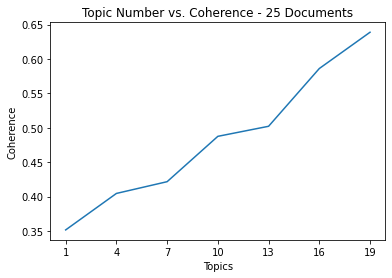

In [65]:
import matplotlib.pyplot as plt

df_results_25.sort_values(by="K", ascending=True, inplace=True)

fig, ax = plt.subplots()

ax.plot(df_results_25.K, df_results_25.coherence)
ax.set_xlabel("Topics")
ax.set_xticks(df_results_25.K)
ax.set_ylabel("Coherence")

ax.set_title("Topic Number vs. Coherence - 25 Documents")

fig.savefig("results/resultset_topicVariation_25-TopicVsCoherence.pdf")

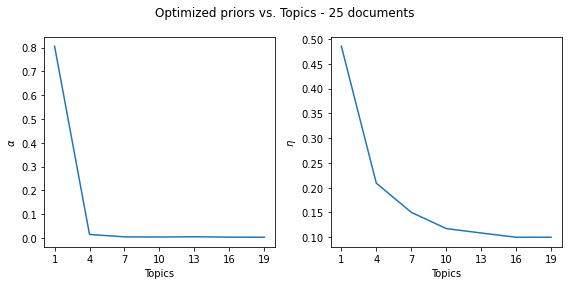

In [66]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
axes = axes.flatten()

df_results_25.sort_values(by="K", ascending=True, inplace=True)
axes[0].plot(df_results_25.K, df_results_25.alpha)
axes[0].set_xlabel("Topics")
axes[0].set_ylabel("$\\alpha$")

df_results_25.sort_values(by="K", ascending=True, inplace=True)
axes[1].plot(df_results_25.K, df_results_25.eta)
axes[1].set_xlabel("Topics")
axes[1].set_ylabel("$\eta$")

for ax in axes:
    ax.set_xticks(df_results_25.K)
    
fig.suptitle("Optimized priors vs. Topics - 25 documents")

plt.tight_layout()

fig.savefig("results/resultset_topicVariation_25-TopicVsOptPriors.pdf")

In [35]:
df_results_50 = pd.read_csv("results/resultset_topicVariation_50.csv")
df_results_50.sort_values(by="coherence", ascending=False)

,N,K,alpha,eta,elbo,coherence,topics,weights
5,50,16,0.005973,0.100000,74611.843750,0.429713,"[['neuron', 'word', 'network', 'rate', 'input'...","[[0.017381677, 0.009928102, 0.0097728195, 0.00..."
2,50,7,0.008261,0.138435,71786.710938,0.417035,"[['network', 'learning', 'neural', 'dropout', ...","[[0.013721937, 0.012301974, 0.007967052, 0.007..."
4,50,13,0.003404,0.100000,69713.257812,0.410035,"[['model', 'reward', 'learning', 'cache', 'fun...","[[0.023894232, 0.013158879, 0.011399826, 0.009..."
1,50,4,0.015376,0.185546,65973.710938,0.393375,"[['model', 'data', 'method', 'problem', 'funct...","[[0.010973792, 0.0090039885, 0.006448609, 0.00..."
6,50,19,0.006242,0.100000,75169.656250,0.391049,"[['data', 'missing', 'variable', 'harmony', 't...","[[0.018523274, 0.014958474, 0.01353298, 0.0116..."
3,50,10,0.006867,0.115626,71214.015625,0.387275,"[['dropout', 'bound', 'probability', 'paramete...","[[0.015388878, 0.01242042, 0.011121718, 0.0091..."
0,50,1,0.079565,0.256711,66543.000000,0.378596,"[['model', 'function', 'network', 'learning', ...","[[0.009019472, 0.007822197, 0.00744305, 0.0067..."


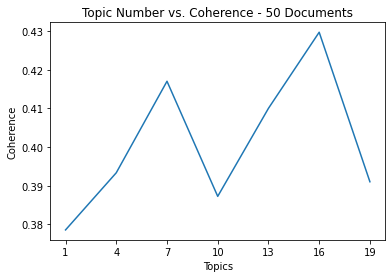

In [67]:
import matplotlib.pyplot as plt

df_results_50.sort_values(by="K", ascending=True, inplace=True)

fig, ax = plt.subplots()

ax.plot(df_results_50.K, df_results_50.coherence)
ax.set_xlabel("Topics")
ax.set_xticks(df_results_50.K)
ax.set_ylabel("Coherence")

ax.set_title("Topic Number vs. Coherence - 50 Documents")

fig.savefig("results/resultset_topicVariation_50-TopicVsCoherence.pdf")

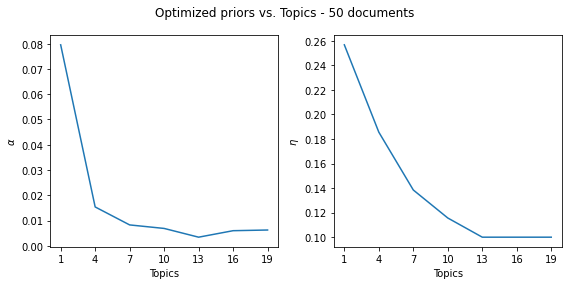

In [68]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
axes = axes.flatten()

df_results_50.sort_values(by="K", ascending=True, inplace=True)
axes[0].plot(df_results_50.K, df_results_50.alpha)
axes[0].set_xlabel("Topics")
axes[0].set_ylabel("$\\alpha$")

df_results_50.sort_values(by="K", ascending=True, inplace=True)
axes[1].plot(df_results_50.K, df_results_50.eta)
axes[1].set_xlabel("Topics")
axes[1].set_ylabel("$\eta$")

for ax in axes:
    ax.set_xticks(df_results_50.K)
    
fig.suptitle("Optimized priors vs. Topics - 50 documents")

plt.tight_layout()

fig.savefig("results/resultset_topicVariation_50-TopicVsOptPriors.pdf")

In [70]:
df_results_100 = pd.read_csv("results/resultset_topicVariation_100.csv")
df_results_100.sort_values(by="coherence", ascending=False)

,N,K,alpha,eta,elbo,coherence,topics,weights
4,100,13,0.019178,0.100000,11161.402344,0.435903,"[['bound', 'data', 'probability', 'algorithm',...","[[0.013034574, 0.012798834, 0.012200965, 0.011..."
2,100,7,0.009491,0.109690,111047.640625,0.425882,"[['model', 'learning', 'probability', 'algorit...","[[0.01328477, 0.006397311, 0.0058774925, 0.005..."
6,100,19,0.001942,0.100000,134790.171875,0.420539,"[['rule', 'data', 'model', 'probability', 'ker...","[[0.012988866, 0.01248891, 0.009864138, 0.0087..."
3,100,10,0.004419,0.100000,122698.781250,0.408730,"[['data', 'model', 'probability', 'method', 'b...","[[0.013800742, 0.008747349, 0.0076546897, 0.00..."
1,100,4,0.012912,0.135554,107229.421875,0.407419,"[['model', 'graph', 'algorithm', 'distribution...","[[0.010513571, 0.0078077954, 0.007412373, 0.00..."
5,100,16,0.003195,0.100000,134941.859375,0.389094,"[['image', 'learning', 'model', 'feature', 'tr...","[[0.011923147, 0.007806312, 0.0075644874, 0.00..."
0,100,1,0.509267,0.163544,132377.593750,0.380533,"[['model', 'algorithm', 'learning', 'function'...","[[0.008687783, 0.0064695245, 0.006439488, 0.00..."


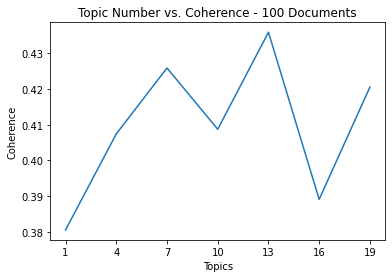

In [71]:
import matplotlib.pyplot as plt

df_results_100.sort_values(by="K", ascending=True, inplace=True)

fig, ax = plt.subplots()

ax.plot(df_results_100.K, df_results_100.coherence)
ax.set_xlabel("Topics")
ax.set_xticks(df_results_100.K)
ax.set_ylabel("Coherence")

ax.set_title("Topic Number vs. Coherence - 100 Documents")

fig.savefig("results/resultset_topicVariation_100-TopicVsCoherence.pdf")

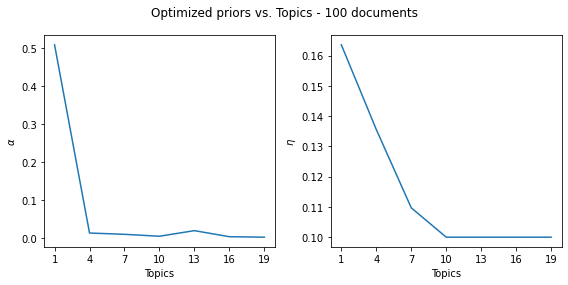

In [72]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
axes = axes.flatten()

df_results_100.sort_values(by="K", ascending=True, inplace=True)
axes[0].plot(df_results_100.K, df_results_100.alpha)
axes[0].set_xlabel("Topics")
axes[0].set_ylabel("$\\alpha$")

df_results_100.sort_values(by="K", ascending=True, inplace=True)
axes[1].plot(df_results_100.K, df_results_100.eta)
axes[1].set_xlabel("Topics")
axes[1].set_ylabel("$\eta$")

for ax in axes:
    ax.set_xticks(df_results_100.K)
    
fig.suptitle("Optimized priors vs. Topics - 100 documents")

plt.tight_layout()

fig.savefig("results/resultset_topicVariation_100-TopicVsOptPriors.pdf")

In [ ]:
# MAX_IT = 10
# EPS = 0.001
# tf.executing_eagerly()
# optim = tf.keras.optimizers.Adam(1e-3)
# # B = ed.Dirichlet(concentration=tf.fill([K, V], 0.1), name="topics")
# # Z = ed.DirichletMultinomial(tf.convert_to_tensor(Ns), concentration=tf.fill([D, K], 0.1))
# alpha = np.copy(alpha_n).astype(np.float32)
# eta = np.copy(eta_n).astype(np.float32)

# beta = np.copy(beta_n).astype(np.float32)
# phi = [np.full((n, K), 1/K).astype(np.float32) for n in Ns]
# gamma = np.copy(gamma_n).astype(np.float32)
# lmbd = np.copy(lmbd_n).astype(np.float32)

# bb = None
# gg = None
# ww = None

# class Positive(tf.keras.constraints.Constraint):
#     def __call__(self, w):
#         return w * tf.cast(tf.math.greater(w, 0.), w.dtype)

# bb = []
# for it in trange(MAX_IT):
#     bb2 = []
#     gg2 = []
#     ww2 = []
#     print('before', gamma)
#     for d in range(D):
#         for n in range(Ns[d]):
#             for i in range(K):
#                 phi[d][n, i] = beta[i, data_enc.iloc[d][n]] * np.exp(digamma(gamma[d, i]) - digamma(np.sum(gamma[d])))
#         phi[d] /= np.sum(phi[d], axis=-1, keepdims=True) + 1e-5
        
#         for i in range(K):
#             gamma[d, i] = alpha[i] + np.sum(phi[d][:, i])
#     print('after', gamma)

#     lmbd = np.full((K, V), eta)
#     for i in range(K):
#         for j in range(V):
#             for d in range(D):
#                 mask = (data_enc.iloc[d] == j)
#                 lmbd[i, j] += np.sum(phi[d][:, i]*mask)
    
     
# #     if bb is None:
# #         bb = bb2
# #         gg = gg2
# #         ww = ww2
# #         break
                
#     alpha_t = tf.Variable(alpha, trainable=True, constraint=Positive())
#     gamma_t = tf.convert_to_tensor(gamma, dtype=tf.float32)
    
    
#     def f_x():
#         g_term = tf.math.reduce_sum(tf.expand_dims((alpha_t - 1), 0)*(tf.math.digamma(gamma_t) - 
#                                                    tf.math.digamma(tf.math.reduce_sum(gamma_t, axis=1, keepdims=True))), axis=1)
#         loss = -tf.math.reduce_sum(tf.math.lgamma(tf.math.reduce_sum(alpha_t)) - tf.math.reduce_sum(tf.math.lgamma(alpha_t)) + g_term)
#         return loss
    
#     for itt in range(10):
#         for i in range(K):
#             for itt1 in range(50):
#                 #with tf.GradientTape() as tape:
#                 optim.minimize(f_x, [alpha_t])
# #                 grads = tape.gradient(loss, opt_a)
# #                 optim.apply_gradients([(grads, opt_a)])
#                 alpha[i] = alpha_t.numpy()[i]
#                 np.nan_to_num(alpha, copy=False, nan=1e-5)
#                 alpha_t.assign(alpha)
#         print(alpha_t)
#     beta = (lmbd - eta) / (np.sum(lmbd - eta, axis=-1, keepdims=True) + 1e-5)
#     break
    
#     eta_t = tf.Variable(eta, trainable=True, constraint=Positive())
    
#     @tf.function
#     def f_eta():
#         loss = K*((eta_t-1)*(tf.math.digamma(eta_t) - tf.math.digamma(eta_t*V)) + tf.math.lgamma(eta_t*V) - V*tf.math.lgamma(eta))
#         return loss
    
#     for itt1 in range(50):
#         optim.minimize(f_eta, [eta_t])
#     eta = eta_t.numpy()

    